This notebook can be used to draw boxes onto the warped frames you generated from the  frames_to_warped_frames.ipynb notebook.

### Imports

In [1]:
import os
import sys
import cv2
import glob
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.modeling import build_model

# our code
sys.path.append('..')
from src.inference import nms_all_classes

/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### TODO

In [2]:
# fill in the path on your machine
models_folder = "/data/huanga/Synchrony/models" # the folder containing the checkpoints of the models
model_name = "best_model" # the name of the model you want to use
warped_frames_folder = "/data/huanga/Synchrony/warped_frames" # the folder containing the warped frames
video_name = "vid_14" # the name of the video you want to process
box_frames_folder = "/data/huanga/Synchrony/box_frames" # the folder where the box frames will be saved

# create the folder if it doesn't exist
os.makedirs(box_frames_folder, exist_ok=True)
os.makedirs(os.path.join(box_frames_folder, video_name), exist_ok=True)

# NOTE: your machine might not have a GPU, in which case you should set the device to "cpu"
# If you have a GPU, you can set the device to "cuda" unless you want to set it to a specific GPU
device = "cuda:3"

### Load the model

In [3]:
# Name of model to evaluate
cfg = get_cfg()
yaml_file = os.path.join(models_folder, model_name, 'config.yaml')
with open(yaml_file, 'r') as f:
    yaml_string = f.read()
cfg = cfg.load_cfg(yaml_string)
# define parameters
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.INPUT.CROP.ENABLED = False
weights_path = sorted(glob.glob(os.path.join(models_folder,  model_name, "best-model-config-iter-*.pth")))[0]
cfg.MODEL.WEIGHTS = weights_path
cfg.MODEL.DEVICE = device
print(weights_path)

# build the model
model = build_model(cfg)
_ = model.eval()
checkpointer = DetectionCheckpointer(model)
_ = checkpointer.load(cfg.MODEL.WEIGHTS)

/data/huanga/Synchrony/models/best_model/best-model-config-iter-3071-loss-0.672501820996827.pth


### Utility functions

In [4]:
def show_image(image):
    plt.figure(figsize=(20,20))
    plt.imshow(image)

def draw_boxes(pil_image, model, device, score_thresh=0.5, iou_thresh=0.05):
    """
    Given an PIL image, draw the bounding boxes on the image and return 
    1) The image with the bounding boxes
    2) The coordinates of the the bounding boxes
    3) The coordinates of the center of the bounding boxes
    """
    # convert the image to the format that the model expects 
    np_image = np.array(pil_image)
    tensor_image = torch.as_tensor(np.array(pil_image).transpose(2, 0, 1).astype("float32")).to(device)
    image_dict = {"image": tensor_image, "height": tensor_image.shape[1], "width": tensor_image.shape[2]}

    final_coords = []
    with torch.no_grad():
        
        # run the model on the image
        detections = model([image_dict])[0]['instances']
        detections = nms_all_classes(detections, iou_thresh)
        boxes = detections.get_fields()["pred_boxes"].tensor.cpu().numpy()
        scores = detections.get_fields()["scores"].cpu().numpy()
        
        # only draw the boxes that have a score greater than the threshold
        for box, score in zip(boxes, scores):
            if score >= score_thresh:
                x1, y1, x2, y2 = box
                cv2.rectangle(np_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                final_coords.append((int((x1+x2)/2), int((y1+y2)/2)))
            
    box_image = Image.fromarray(np_image)  
    return {
        "image": box_image,
        "coords": np.array(final_coords)
    }

### Start drawing boxes

In [5]:
frame_files = sorted(glob.glob(os.path.join(warped_frames_folder, video_name, "*.jpg")))
print(f"Processing {len(frame_files)} frames.")

Processing 539 frames.


### Sanity check on the first frame

Run inference on the first frame to determine the proper score threshold and IoU threshold for the video.
Usually, the thresholds that work on the first frame will work on the rest of the frames.

/u/h/u/huanga/miniconda3/envs/drone_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


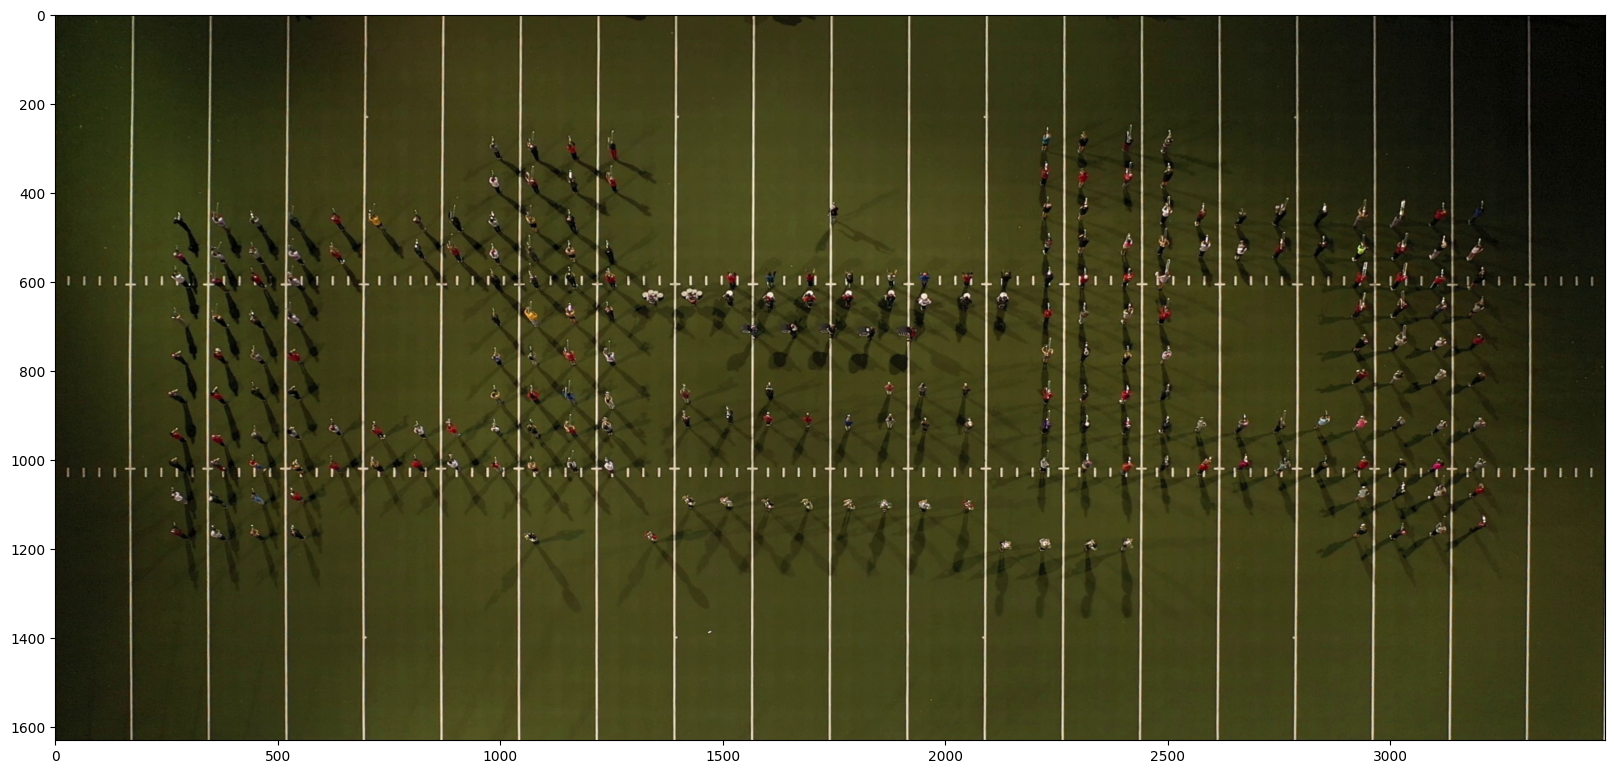

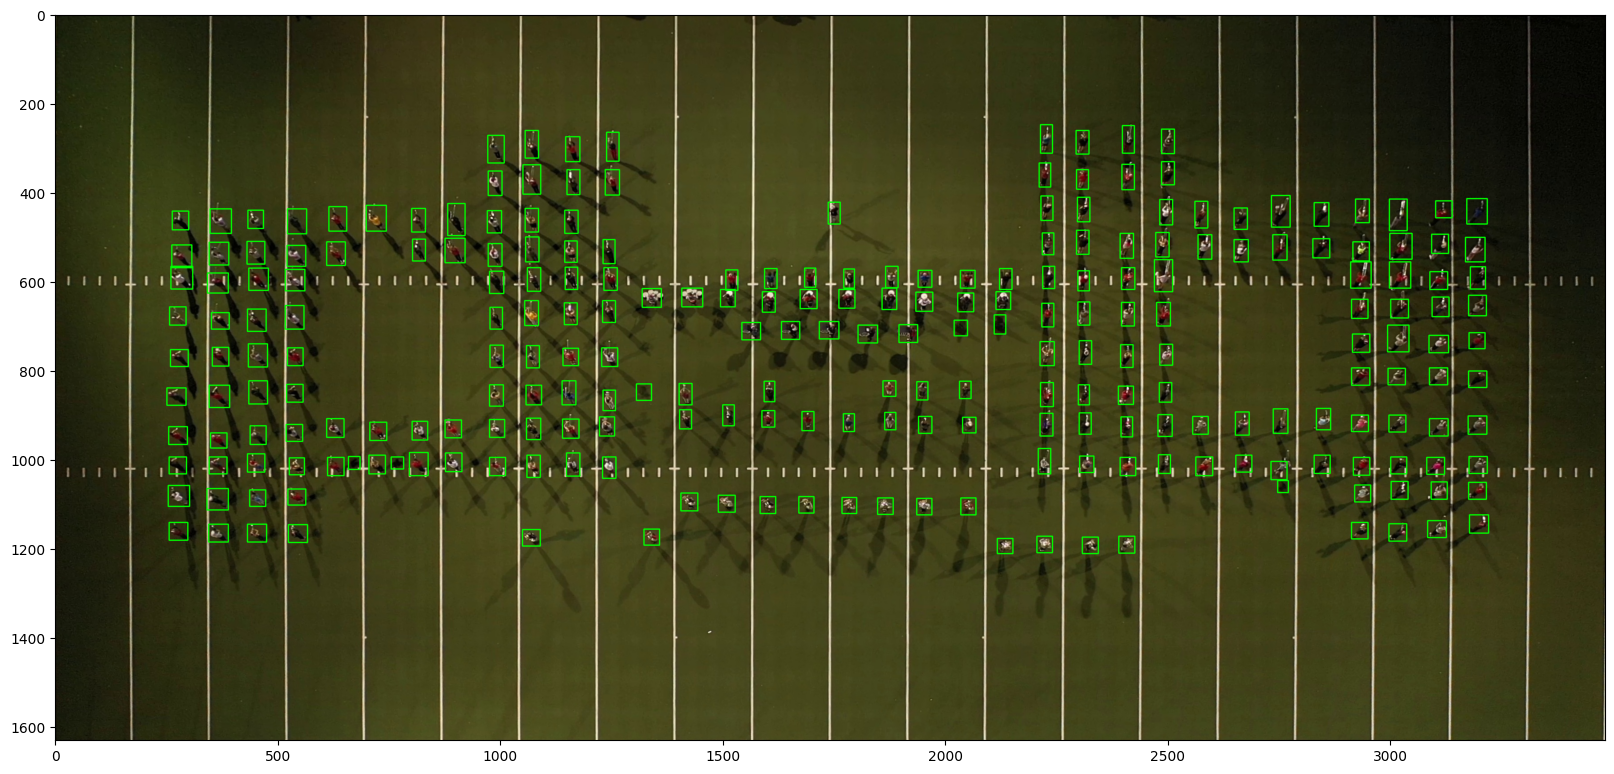

In [6]:
#TODO: play around with the threshold values. Modify the score_thresh and iou_thresh values if the results are not satisfactory
score_thresh = 0.78 # the minimum score for a box to be considered as a valid box
iou_thresh = 0.05 # the minimum iou for two boxes to be considered as the same box

image_1 = Image.open(frame_files[0])
result_dict = draw_boxes(image_1, model, device, score_thresh=score_thresh, iou_thresh=iou_thresh)

show_image(image_1)
show_image(result_dict["image"])

### Draw boxes on the rest of the frames

In [7]:
coord_dict = []
for i, frame_file in tqdm(enumerate(sorted(frame_files), start=1), total=len(frame_files)):
    
    # load the frame and draw the boxes
    image = Image.open(frame_file)
    result_dict = draw_boxes(image, model, device, score_thresh=score_thresh, iou_thresh=iou_thresh)
    
    # save the frame with the boxes
    box_frame = result_dict["image"]
    box_frame.save(os.path.join(box_frames_folder, video_name, f"frame_{i:04d}.jpg"))
    
    # save the coordinates of the boxes
    coord = result_dict["coords"]
    coord_dict.append(coord)

  0%|          | 2/539 [00:00<02:37,  3.42it/s]

100%|██████████| 539/539 [02:24<00:00,  3.74it/s]


In [8]:
coord_dict = np.array(coord_dict, dtype=object)
np.save(os.path.join(box_frames_folder, video_name, "coords.npy"), coord_dict)